<a href="https://colab.research.google.com/github/taiyang2525/Prog2kakushin/blob/main/work3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Colabのセッションをリセットする（必要に応じて）
#!kill -9 -1

# 名刺リーダー
名刺リーダーです．名刺の表面をPDFでアップロードすると自動的に名前，勤務先，電話番号をまとめた連絡先ファイル（vcard形式）で出力します．

日本語の名刺に対応しています．

読み込み精度が少し低いですが，ご容赦ください．

もしよろしければ，先生のお名刺もお試しください．

名前の読み取り精度に一部難があります．あらかじめご了承ください．

In [1]:
#名刺サンプルです．読み込む名刺がなければ，ここでダウンロードください
!wget "https://drive.google.com/uc?export=download&id=1fBQCKfn9rK_ITapU0WoRPIjKUfXX0RYe" -O images.zip
!unzip -o images.zip

--2024-01-18 11:56:27--  https://drive.google.com/uc?export=download&id=1fBQCKfn9rK_ITapU0WoRPIjKUfXX0RYe
Resolving drive.google.com (drive.google.com)... 74.125.143.138, 74.125.143.101, 74.125.143.100, ...
Connecting to drive.google.com (drive.google.com)|74.125.143.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1fBQCKfn9rK_ITapU0WoRPIjKUfXX0RYe&export=download [following]
--2024-01-18 11:56:28--  https://drive.usercontent.google.com/download?id=1fBQCKfn9rK_ITapU0WoRPIjKUfXX0RYe&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 108.177.127.132, 2a00:1450:4013:c07::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|108.177.127.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 516568 (504K) [application/octet-stream]
Saving to: ‘images.zip’

images.zip          100%[===================>] 504.46K  --.-KB/s   

#環境構築

一度だけ実行してください

In [2]:
!pip install pymupdf
!pip install PyPDF2
!apt install tesseract-ocr libtesseract-dev tesseract-ocr-jpn
!pip install pyocr
!pip install urlextract

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 3.9 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libarchive-dev libleptonica-dev tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  libarchive-dev libleptonica-dev libtesseract-dev tesseract-ocr tesseract-ocr-eng
  tesseract-ocr-jpn tesseract-ocr-osd
0 upgraded, 7 newly installed, 0 to remove and 24 not upgraded.
Need to get 9,950 kB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libarchive-dev amd64 3.6.0-1ubuntu1 [581 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libleptonica-dev amd64 1.82.0-3build1 [1,56

#名刺データ（PDF）から連絡先情報を作成する

In [3]:
#ライブラリのインポート
import cv2
import os
from google.colab import files
import PyPDF2
import fitz  # PyMuPDFのモジュール
from PIL import Image
import pyocr
from google.colab.patches import cv2_imshow
import re
import unicodedata
import numpy as np
from urlextract import URLExtract

Saving meishi5.pdf to meishi5 (2).pdf


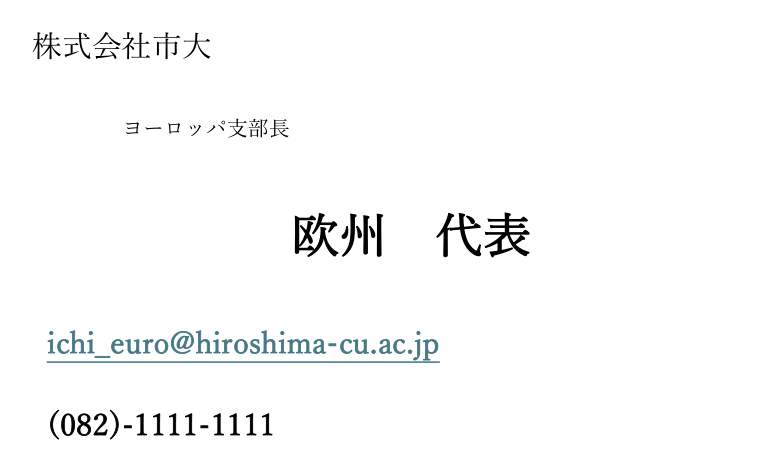

読み込んだ名刺を表示しています
（PDFの１ページ目を読み込みます．）
お名前は次のように読み込まれました．： 欧州代表
間違いがあれば入力してください．なければそのままエンターを押してください
勤務先は次のように読み込まれました．： 株式会社市大
間違いがあれば入力してください．なければそのままエンターを押してください：
電話番号は次のように読み込まれました．： 08211111111
間違いがあれば入力してください．なければそのままエンターを押してください：
メールアドレスは次のように読み込まれました．： ichi_euro@hiroshima-cu.ac.jp
間違いがあれば入力してください．なければそのままエンターを押してください：


In [6]:
def match(list, word):
  """
  match(argument: list, argument: str)
  リスト内のすべての要素を捜索し，文字列wordが含まれる最初の文字列，list[i]のiの値を返す
  見つからなかった場合は-1を返す
  return int
  """
  for i in range(len(list)):
    if word in list[i]:
      return i
  return -1

def del_hy(phone):
  """
  del_hy(argument: str)
  文字列phoneの中にある 文字"-"を見つけ，省略したものnumを返すプログラム
  電話番号のハイフンを省略することに利用します．
  return str
  """

  num = ""
  for i in phone:
    if i != "-":
      num = num + i
  return num


def zenkaku(FN):
  """
  zenkaku(str)
  全角文字かどうかを判定するプログラム，テキストがすべて全角なら，Trueを返す
  return bool
  """
  for i in FN:
    if unicodedata.east_asian_width(i) != "W":
      return False
  return True


def find_fullname(content):
  """
  find_fullname(argument: list)
  この関数は与えられたリスト内にある日本人のフルネームを捜索します．
  ただし，content[n]に姓名，content[n + 1]に名前が格納され，かつ，姓名は４文字以内全角であることを仮定しています．
  また，実行時に上で定義されているzenkaku関数を用います．（全角判定）
  これらの設定は以下のコードを変更することで調整できます．
  """

  for i in range(len(content)-1):
    #日本人の姓名は4文字以内と仮定し，かつ次のインデックスに名前が格納されていると仮定
    if 0 < len(content[i]) <= 4:

      #性と名前を合体させる
      fullname = content[i] + content[i + 1]
      if zenkaku(fullname) == True:
        return fullname
  #for終了時（名前の捜索に失敗したら空白を返す）
  return ""

def find_org(content):
  """
  find_org(argument: list)
  リストをfor文で回し，「会社」や「大学」といった文字が含まれる要素を特定．
  そのリストの値（str）を返します．
  return str
  """

  if match(content, "大学") >= 0:
    company = content[match(content, "大学")]
  elif match(content, "会社") >= 0:
    company = content[match(content, "会社")]
  else:
    company = ""
  return company

def find_number(txt1):
  """
  find_number(argument: str)
  正規表現を用いて引数（str）の中で電話番号を探し，見つかれば返します（str）
  その際，ハイフンが含まれる場合は，ハイフンを省略して返します．
  （del_hy関数を使用）
  return str
  """
  text = ""
  for i in txt1:
    #tex1の中に括弧（電話番号）が含まれる
    if i == "(" or i == ")" or i == "（" or i == "）":
      #テキストはそのまま
      text = text
    else:
      text = text + i

  pattern = r"\d{2,4}-\d{2,4}-\d{4}"

  if re.search(pattern, text) is not None:
    number = re.search(pattern, text).group()
    number = del_hy(number)
  else:
    pattern = r"\d{10, 11}"
    if re.search(pattern, text) is not None:
      number = re.search(pattern, text).group()
    else:
      number = ""
  return number

def find_email(txt1):
  """
  find_email(argument: str)
  文字列からEメールアドレスを見つけ，返します．
  return str
  """
  extractor = URLExtract()
  extractor.extract_email=True
  urls = extractor.find_urls(txt1)
  for i in urls:
    if i.find("@") >0:
      return i
  return ""



def cv2pil(image):
    ''' OpenCV型 -> PIL型 '''
    new_image = image.copy()
    if new_image.ndim == 2:  # モノクロ
        pass
    elif new_image.shape[2] == 3:  # カラー
        new_image = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)
    elif new_image.shape[2] == 4:  # 透過
        new_image = cv2.cvtColor(new_image, cv2.COLOR_BGRA2RGBA)
    new_image = Image.fromarray(new_image)
    return new_image


def information_reader(f_name):
  """
  infromation_reader(argument: string filepath of an image)
  information_reader(画像のパス)
  この関数は引数に名刺画像のパスを入力し，フルネーム，勤務先，電話番号，メールアドレスを抽出したものを返すものです．
  この関数は他のライブラリや上に定義した他の関数も用いることをご理解ください
  """

  #色を変えながら3回名刺情報を読み取る
  card = ["", "", "", ""] #名前，所属，電話番号，メールを格納するリスト
  img_color = Image.open(f_name)
  #グレースケール
  img_gray = cv2.imread(f_name, cv2.IMREAD_GRAYSCALE)
  #２値化用
  img_bit = cv2.imread(f_name, cv2.IMREAD_GRAYSCALE)
  h = img_bit.shape[0] # 画像の高さ
  w = img_bit.shape[1] # 画像の幅

  th = 100  # しきい値

  for iy in range(h):
    for ix in range(w):
      if img_bit[iy,ix] >= th:
        img_bit[iy,ix] = 255
      else:
        img_bit[iy,ix] = 0

  #2値化完了

  #GBR⇒RGBに変える
  img_gray = cv2.cvtColor(img_gray, cv2.COLOR_BGR2RGB)
  img_bit = cv2.cvtColor(img_bit, cv2.COLOR_BGR2RGB)

  #OpenCVをPillowに変える
  img_gray = cv2pil(img_gray)
  img_bit = cv2pil(img_bit)

  #3つの画像をリスト化してまとめて処理する
  imgs = [img_color, img_gray, img_bit]

  #OCRの情報を読み込む
  tools = pyocr.get_available_tools()
  tool = tools[0]

  content = [] #名刺の読み込み情報

  #forでまとめて処理
  #iはそれぞれの画像
  for i in imgs:
    #名刺画像全体を読み込んだテキスト：txt1
    txt1 = tool.image_to_string(
      i,
      lang='jpn+eng',
      builder=pyocr.builders.TextBuilder(tesseract_layout=6)
    )


    #処理用変数
    aptext = ""

    #リストで日本語の単語に分ける処理
    #txt1で取得したテキストを１文字ずつ処理
    for w in txt1:
      #空白または改行（単語の切れ目）なら
      if w == " " or w == "\n":
        #単語が切れるまで格納
        content.append(aptext)
        aptext = ""
      else:
        #文字を１文字追加（単語の切れ目まで続く）
        aptext = aptext + w


    #AND条件
    #①既にcard[n] (フルネーム，電話番号．．．）が読み込まれていないなら
    #②fullname関数にcontentを渡したときに，読み取り不能（"")でないか
    #処理：格納していく
    if card[0] == "" and find_fullname(content) != "":
      card[0] = find_fullname(content)
    if card[1] == "" and find_org(content) != "":
      card[1] = find_org(content)
    if card[2] == "" and find_number(txt1) != "":
      card[2] = find_number(txt1)
    if card[3] == "" and find_email(txt1) != "":
      card[3] = find_email(txt1)

    #for文n回目が終わるので，contentをリセットする（単語リストのリセット）
    content = []
  return card


"""main"""
#ここからスタート
#Colabにファイルをアップロードする
uploaded = files.upload()

#拡張子の確認
if list(uploaded.keys())[0].endswith('.pdf') == False:
  print('pdfファイルをアップロードしてください．')
else:
  #PDFの最初の１ページのみを取り出す処理
  #２ページ以上のPDF（名刺）が読み込まれた場合は１枚目のみ（表面）

      with open(list(uploaded.keys())[0], 'rb') as file:
        # PyPDF2のPdfFileReaderオブジェクトを作成
        pdf_reader = PyPDF2.PdfReader(file)

        # 新しいPdfFileWriterオブジェクトを作成
        pdf_writer = PyPDF2.PdfWriter()

        # 最初のページを抽出して追加
        first_page = pdf_reader.pages[0]

        pdf_writer.add_page(first_page)

        # 出力ファイルに書き込む
        with open('bcard.pdf', 'wb') as output_file:
            #bcard.pdfとして出力
            pdf_writer.write('bcard.pdf')

      # PDFを画像に変換

      # 1つの画像をPDFに変換する
      pdf_document = fitz.open('bcard.pdf')

      # 最初のページを取得
      first_page = pdf_document[0]

      # ページを画像に変換
      image = first_page.get_pixmap(matrix=fitz.Matrix(3, 3))

      # 画像を保存
      #bcard.pngで保存
      image.save('bcard.png')

      # PDFを閉じる
      pdf_document.close()

      #bcard.pngを表示（読み込み結果）
      img = cv2.imread('bcard.png')
      cv2_imshow(img)

      print('読み込んだ名刺を表示しています')
      print('（PDFの１ページ目を読み込みます．）')

      #information_reader関数（def済み）
      data = information_reader('bcard.png')
      name = data[0] #名前
      company = data[1] #会社名
      number = data[2] #電話番号
      email = data[3] #メールアドレス

      #名前の処理
      if name == "":
        print('お名前の読み込みに失敗しました．')
        name = input('お名前を入力してください．：')
      else:
        print('お名前は次のように読み込まれました．：', name)
        name = input('間違いがあれば入力してください．なければそのままエンターを押してください') or name

      #会社名処理
      if company == "":
        print('勤務先の読み込みに失敗しました．')
        company = input('勤務先を入力してください．：')
      else:
        print('勤務先は次のように読み込まれました．：', company)
        company = input('間違いがあれば入力してください．なければそのままエンターを押してください：') or company

      #電話番号
      if number == "":
        print('電話番号の読み込みに失敗しました．')
        number = input('電話番号を入力してください．：')
      else:
        print('電話番号は次のように読み込まれました．：', number)
        number = input('間違いがあれば入力してください．なければそのままエンターを押してください：') or number
        #ハイフンを削除
        number = del_hy(number)
            #電話番号
      if email == "":
        print('メールアドレスの読み込みに失敗しました．')
        email = input('メールアドレスを入力してください．：')
      else:
        print('メールアドレスは次のように読み込まれました．：', email)
        email = input('間違いがあれば入力してください．なければそのままエンターを押してください：') or email

## 連絡先データとして出力

以下のセルを実行するとvcf形式で読み込んだ名刺に記載の名前，勤務先，電話番号，メールアドレスを出力します！

In [7]:
with open(name + '.vcf', 'w', encoding = 'utf-8') as f:
  f.write('BEGIN:VCARD\n')
  f.write('VERSION:3.0\n')
  f.write('FN:' + name + '\n')
  f.write('ORG:' + company + '\n')
  f.write('TEL:' + number + '\n')
  f.write('EMAIL:' + email +'\n')
  f.write('END:VCARD')
print(name + 'さんのデータを出力しました．')

欧州代表さんのデータを出力しました．
